In [1]:
include("graph_ops.jl")
using LinearAlgebra

function dense(w, b, x, activation) return activation(w * x .+ b) end
function dense(w, x, activation) return activation(w * x) end
function dense(w, x) return w * x end

function mean_squared_loss(y, ŷ)
    return ConstantNode(0.5) .* ((y .- ŷ) .^ ConstantNode(2))
end

function net(x, wh, wo, y)
    x̂ = dense(wh, x, tanh)
    ŷ = dense(wo, x̂)
    E = mean_squared_loss(y, ŷ)

    return topological_sort(E), ŷ
end

function net2(x, wh, bias, wo, y)
    x̂ = dense(wh, bias, x, tanh)
    ŷ = dense(wo, x̂)
    E = mean_squared_loss(y, ŷ)

    return topological_sort(E), ŷ
end


net2 (generic function with 1 method)

In [2]:
Wh  = VariableNode(randn(50,1))
Wh2  = VariableNode(randn(1,50))
Wo  = VariableNode(randn(1,50))
bias = VariableNode(randn(50,1))
x = InputNode([4.434])
y = InputNode([0.064])
losses = Float64[]



graph, target = net2(x, Wh,bias, Wo, y)
# graph, target = net2(x, Wh,Wh2, Wo, y)

init_nodes!(graph)


In [3]:
import Base: sin
data = [([i], [sin(i)]) for i in 0:0.1:7]

71-element Vector{Tuple{Vector{Float64}, Vector{Float64}}}:
 ([0.0], [0.0])
 ([0.1], [0.09983341664682815])
 ([0.2], [0.19866933079506122])
 ([0.3], [0.29552020666133955])
 ([0.4], [0.3894183423086505])
 ([0.5], [0.479425538604203])
 ([0.6], [0.5646424733950354])
 ([0.7], [0.644217687237691])
 ([0.8], [0.7173560908995228])
 ([0.9], [0.7833269096274834])
 ⋮
 ([6.2], [-0.0830894028174964])
 ([6.3], [0.016813900484349713])
 ([6.4], [0.11654920485049364])
 ([6.5], [0.21511998808781552])
 ([6.6], [0.31154136351337786])
 ([6.7], [0.4048499206165983])
 ([6.8], [0.49411335113860816])
 ([6.9], [0.5784397643882002])
 ([7.0], [0.6569865987187891])

In [4]:
n_epochs = 100
lr = 0.02
data_size = length(data)
losses = Float64[]
Wh_acc_gradient = zeros(size(Wh.output))
bias_acc_gradient = zeros(size(bias.output))
Wo_acc_gradient = zeros(size(Wo.output))

for epoch in 1:n_epochs
    fill!(Wh_acc_gradient, 0)
    fill!(Wo_acc_gradient, 0)
    loss_in_epoch = 0
    for (x_, y_) in data
        x.output = x_
        y.output = y_
        currentloss = forward!(graph)
        backward!(graph)
        loss_in_epoch += first(currentloss)
        Wh_acc_gradient += Wh.gradient
        bias_acc_gradient += bias.gradient
        Wo_acc_gradient += Wo.gradient
    end
    Wh.output -= lr*(Wh_acc_gradient ./ data_size)
    bias_acc_gradient -= lr*(bias_acc_gradient ./ data_size)
    Wo.output -= lr*(Wo_acc_gradient ./ data_size)
    println("Current loss: ", loss_in_epoch/data_size)
    push!(losses, first(loss_in_epoch/data_size))
end


Current loss: 54.96324340405652
Current loss: 2.770071069034319
Current loss: 1.815953843904832
Current loss: 1.5156535560706896
Current loss: 1.3173378176372252
Current loss: 1.191154180388616
Current loss: 1.0904073540096855
Current loss: 1.0056383119645893
Current loss: 0.9323520824813643
Current loss: 0.867861817727879
Current loss: 0.8103863108363505
Current loss: 0.7586787394244109
Current loss: 0.7118268452266209
Current loss: 0.669139233833201
Current loss: 0.6300767332915373
Current loss: 0.5942087661123636
Current loss: 0.5611843808784488
Current loss: 0.5307123173582923
Current loss: 0.5025468917698407
Current loss: 0.4764777782989337
Current loss: 0.4523224836455348
Current loss: 0.42992073173028195
Current loss: 0.4091302310308322
Current loss: 0.3898234581697183
Current loss: 0.37188519679667753
Current loss: 0.35521064208484937
Current loss: 0.33970393079568106
Current loss: 0.3252769923252491
Current loss: 0.3118486420153283
Current loss: 0.2993438572059812
Current loss

In [5]:
import Base: sin
data_dense_x = 0:0.1:7
data_dense_y = sin.(data_dense_x)

using Plots
xx = 0:0.01:7
yy = Vector{Float64}(undef, length(xx))

701-element Vector{Float64}:
 8.225664627795e-312
 8.22566462803e-312
 8.22566462827e-312
 8.225664628744e-312
 8.22566462969e-312
 8.22566462993e-312
 8.225664630167e-312
 8.22566463064e-312
 8.22566463088e-312
 8.225664632775e-312
 ⋮
 8.23191569931e-312
 8.231915699546e-312
 8.231915699783e-312
 8.23191570002e-312
 8.23191570026e-312
 8.231915700495e-312
 8.23191570073e-312
 8.23191570097e-312
 8.231915701206e-312

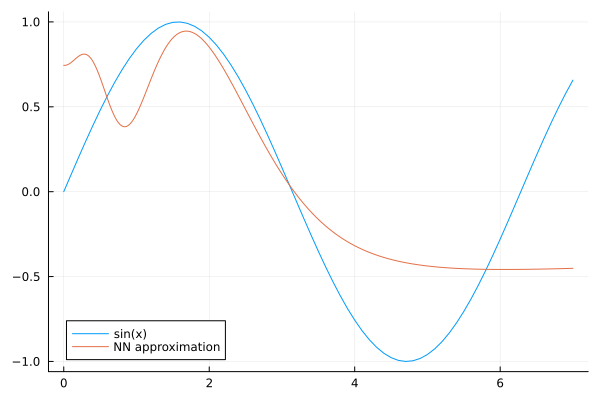

In [6]:


for i in 1:length(xx)
    yy[i] = predict!([xx[i]], x,target, graph)[1]
end

plot(data_dense_x, data_dense_y, label="sin(x)")
plot!(xx, yy, label="NN approximation")
